In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)
import missingno as msno
import os

DATA_PATH = '/opt/ml/input/data'

In [2]:
%%time
dtype = {
    'userID': 'int16',
    'answerCode': 'int8',
    'KnowledgeTag': 'int16'
}   

train_df = pd.read_csv(os.path.join(DATA_PATH, 'train_data.csv'), dtype=dtype, parse_dates=['Timestamp'])
train_df = train_df.sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

test_df = pd.read_csv(os.path.join(DATA_PATH, 'test_data.csv'), dtype=dtype, parse_dates=['Timestamp'])

CPU times: user 4.57 s, sys: 432 ms, total: 5 s
Wall time: 5.01 s


+ `userID` 사용자의 고유 번호입니다. 총 7,442명의 학생이 있습니다.   
+ `assessmentItemID` 사용자가 푼 문항의 일련 번호입니다.   
+ `testId` 사용자가 푼 문항이 포함된 시험지의 일련 번호입니다.   
+ `answerCode` 사용자가 푼 문항의 정답 여부를 담고 있는 이진 (0/1) 데이터입니다.   
+ `Timestamp` 사용자가 문항을 푼 시간 정보입니다.   
+ `KnowledgeTag` 사용자가 푼 문항의 고유 태그가 담겨져 있습니다.

train_df와 test_df를 합쳐서 학습 시킬 수 있음!

# 검증 전략

우리가 예측해야 할 데이터는 결국 유저가 푼 마지막 문제이기 때문에 유저 기준으로 데이터를 나누고 맞춰야 할 부분을 마지막 시퀀스로 두기

+ train = 유저 마지막 시퀀스 이전 까지의 모든 문제 풀이
+ val - 유저 마지막 시퀀스

In [3]:
df = pd.concat([train_df, test_df]).sort_values(by=['userID', 'Timestamp']).reset_index(drop=True)

# assessmentItemID

ABBBBBBCCC

+ A는 무조건 알파벳
+ B는 시험지 번호
+ C는 시험지 내 문항의 번호

In [3]:
def get_paper_number(x):
    return x[1:-3]

def get_paper_question_number(x):
    return x[-3:]

def get_large_paper_number(x):
    return x[1:4]

In [5]:
df['paper_number'] = df['assessmentItemID'].apply(lambda x : get_paper_number(x))
df['paper_question_number'] = df['assessmentItemID'].apply(lambda x : get_paper_question_number(x))
df['large_paper_number'] = df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

# 각 유저별 푼 시험지의 개수

사용자마다 푸는 시험지가 다름

In [11]:
df.groupby('userID').nunique()['testId'].describe()

count    7442.000000
mean       54.714996
std        50.853361
min         2.000000
25%        13.000000
50%        39.000000
75%        84.000000
max       301.000000
Name: testId, dtype: float64

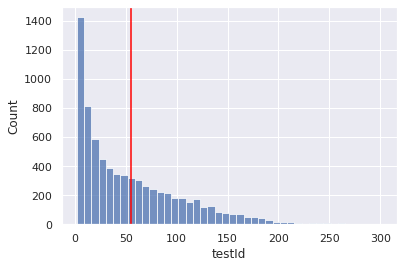

In [8]:
sns.histplot(df.groupby('userID').nunique()['testId'])
plt.axvline(df.groupby('userID').nunique()['testId'].mean(), color='red')
plt.show()

# 각 변수별 고유값의 개수

In [9]:
print(f"""--- BASIC INFORMATIONS ---
userID           : {df.userID.nunique()}
assessmentItemID : {df.assessmentItemID.nunique()}
testID           : {df.testId.nunique()}
mean answer rate : {df[df['answerCode'] != -1].answerCode.sum() / df.shape[0] * 100:.2f}%
KnowledgeTag     : {df.KnowledgeTag.nunique()}
{'-'*26}""")

--- BASIC INFORMATIONS ---
userID           : 7442
assessmentItemID : 9454
testID           : 1537
mean answer rate : 65.44%
KnowledgeTag     : 912
--------------------------


# 각 유저별 푼 문항의 개수

In [10]:
def percentile(s):
    return np.sum(s) / len(s)

stu_groupby = df.groupby('userID').agg({
    'assessmentItemID': 'count',
    'answerCode': percentile
})
stu_groupby.describe()

,assessmentItemID,answerCode
count,7442.000000,7442.000000
mean,339.518947,0.627057
std,321.468413,0.160039
min,9.000000,0.000000
25%,78.000000,0.525133
50%,232.500000,0.650344
75%,519.000000,0.750000
max,1860.000000,1.000000


/tmp/ipykernel_8613/417151868.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


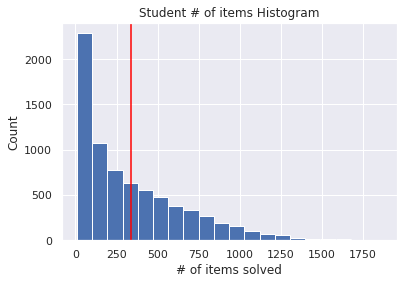

In [23]:
fig, ax = plt.subplots()

stu_groupby['assessmentItemID'].hist(bins=20, ax=ax)

ax.set_title('Student # of items Histogram')
ax.set_xlabel('# of items solved')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['assessmentItemID'].mean(), color='red')
ax.grid(b=True)

# 사용자 정답률 분포표

/tmp/ipykernel_8613/1795024208.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax.grid(b=True)


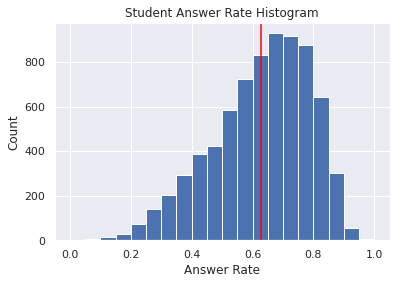

In [24]:
fig, ax = plt.subplots()

stu_groupby['answerCode'].hist(bins=20)

ax.set_title('Student Answer Rate Histogram')
ax.set_xlabel('Answer Rate')
ax.set_ylabel('Count')
ax.axvline(stu_groupby['answerCode'].mean(), color='red')
ax.grid(b=True)

# 시험지별 정답률

In [13]:
df.groupby('paper_number').mean()['answerCode']

paper_number
010001    0.923429
010002    0.931429
010003    0.842857
010004    0.880571
010005    0.849143
            ...   
090070    0.457500
090071    0.345000
090072    0.453333
090073    0.536667
090074    0.420000
Name: answerCode, Length: 1537, dtype: float64

# 문항별 정답률

In [16]:
df.groupby('assessmentItemID').mean()['answerCode']

assessmentItemID
A010001001    0.922857
A010001002    0.960000
A010001003    0.905714
A010001004    0.945714
A010001005    0.882857
                ...   
A090074002    0.480000
A090074003    0.580000
A090074004    0.360000
A090074005    0.400000
A090074006    0.360000
Name: answerCode, Length: 9454, dtype: float64

# 간단한 데이터 전처리

In [47]:
train_df['paper_number'] = train_df['assessmentItemID'].apply(lambda x : get_paper_number(x))
train_df['paper_question_number'] = train_df['assessmentItemID'].apply(lambda x : get_paper_question_number(x))
train_df['large_paper_number'] = train_df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

test_df['paper_number'] = test_df['assessmentItemID'].apply(lambda x : get_paper_number(x))
test_df['paper_question_number'] = test_df['assessmentItemID'].apply(lambda x : get_paper_question_number(x))
test_df['large_paper_number'] = test_df['assessmentItemID'].apply(lambda x : get_large_paper_number(x))

In [48]:
import random

total_user_list = train_df['userID'].unique().tolist()

random.seed(22)
val_user_list = random.sample(total_user_list, test_df['userID'].nunique())

In [49]:
train = []
valid = []
test = []

group_df = train_df.groupby('userID')

for userID, df in group_df:
    if userID in val_user_list:
        trn_df = df.iloc[:-1, :]
        val_df = df.iloc[-1:, :]

        train.append(trn_df)
        valid.append(val_df)
    else:
        train.append(df)

group_df = test_df.groupby('userID')

for userID, df in group_df:
    trn_df = df.iloc[:-1, :]
    te_df = df.iloc[-1:, :]

    train.append(trn_df)
    test.append(te_df)

train = pd.concat(train)
valid = pd.concat(valid)
test = pd.concat(test)

# 문항의 평균 정답률

유저의 맞춰야할 문항의 평균 정답률로 해당 값을 예측해본다. 결국 비슷하게 틀리거나 맞지 않았을까? 라는 가정으로

In [50]:
taget_assessmentItemID = valid['assessmentItemID'].unique().tolist()
assessmentItemID2val = {}

for i in train.set_index('assessmentItemID').loc[taget_assessmentItemID, 'answerCode'].reset_index().groupby('assessmentItemID').mean().iloc:
    assessmentItemID2val[i.name] = i.answerCode

In [51]:
val_target = valid['answerCode'].tolist()
val_pred = [assessmentItemID2val[assessmentItemID] for assessmentItemID in valid['assessmentItemID'].tolist()]

In [52]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val_target, val_pred)

0.7019158473105841

In [58]:
all_df = pd.concat([train, valid])
taget_assessmentItemID = test['assessmentItemID'].unique().tolist()
assessmentItemID2val = {}

for i in all_df.set_index('assessmentItemID').loc[taget_assessmentItemID, 'answerCode'].reset_index().groupby('assessmentItemID').mean().iloc:
    assessmentItemID2val[i.name] = i.answerCode

In [66]:
submission = pd.DataFrame(data = np.array([assessmentItemID2val[assessmentItemID] for assessmentItemID in test['assessmentItemID'].tolist()]), columns = ['prediction'])
submission['id'] = submission.index
submission = submission[['id', 'prediction']]
submission.to_csv('baseline.csv', index = False)

# 간단한 LGBM

In [24]:
def get_val2idx(val_list : list) -> dict:
    val2idx = {}
    for idx, val in enumerate(val_list):
        val2idx[val] = idx
    
    return val2idx

all_df = pd.concat([train, valid, test])

assessmentItemID2idx = get_val2idx(all_df['assessmentItemID'].unique().tolist())
testId2idx = get_val2idx(all_df['testId'].unique().tolist())
KnowledgeTag2idx = get_val2idx(all_df['KnowledgeTag'].unique().tolist())
large_paper_number2idx = get_val2idx(all_df['large_paper_number'].unique().tolist())

train['assessmentItemID2idx'] = train['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
train['testId2idx'] = train['testId'].apply(lambda x : testId2idx[x])
train['KnowledgeTag2idx'] = train['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
train['large_paper_number2idx'] = train['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

valid['assessmentItemID2idx'] = valid['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
valid['testId2idx'] = valid['testId'].apply(lambda x : testId2idx[x])
valid['KnowledgeTag2idx'] = valid['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
valid['large_paper_number2idx'] = valid['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

test['assessmentItemID2idx'] = test['assessmentItemID'].apply(lambda x : assessmentItemID2idx[x])
test['testId2idx'] = test['testId'].apply(lambda x : testId2idx[x])
test['KnowledgeTag2idx'] = test['KnowledgeTag'].apply(lambda x : KnowledgeTag2idx[x])
test['large_paper_number2idx'] = test['large_paper_number'].apply(lambda x : large_paper_number2idx[x])

In [ ]:
from lightgbm import LGBMClassifier

cols = ['userID', 'assessmentItemID2idx', 'testId2idx', 'KnowledgeTag2idx', 'large_paper_number2idx']
taget = 'answerCode'

model = LGBMClassifier(random_state = 22,  n_estimators= 5000)
model.fit(X = train[cols], y = train[taget], eval_set = (valid[cols], valid[taget]), verbose = True, eval_metric='auc')

In [38]:
pd.DataFrame(index = cols, data = model.feature_importances_)

,0
userID,69793
assessmentItemID2idx,27440
testId2idx,14206
KnowledgeTag2idx,29192
large_paper_number2idx,9369


In [33]:
val_target = valid['answerCode'].tolist()
val_pred = model.predict_proba(valid[cols])[:, 1].tolist()

In [35]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val_target, val_pred)

0.6875975997686524

# 메트릭 확인

In [65]:
from sklearn.metrics import roc_auc_score

y = [0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]

roc_auc_score(y, y_pred)

0.5

In [66]:
y = [0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0.4, 0.4, 0.4, 0.4, 0.5, 0.5, 0.5, 0.5]

roc_auc_score(y, y_pred)

1.0

In [67]:
y = [0, 0, 0, 0, 1, 1, 1, 1]
y_pred = [0.1, 0.1, 0.1, 0.1, 0.11, 0.11, 0.11, 0.11]

roc_auc_score(y, y_pred)

1.0

# 시험지별 평균 정답율

In [110]:
testId2mean_val = {}

for testId, mean_val in zip(train.groupby('testId').mean()['answerCode'].index, train.groupby('testId').mean()['answerCode'].values):
    testId2mean_val[testId] = mean_val

In [111]:
from collections import defaultdict

high_user_list = defaultdict(list)
low_user_list = defaultdict(list)

g_df = train.groupby('testId')

for testId, df in g_df:
    gg_df = df.groupby('userID')
    for userID, df in gg_df:
        val = df['answerCode'].mean()
        if val < testId2mean_val[testId]:
            low_user_list[testId] += [userID]
        else:
            high_user_list[testId] += [userID]

In [ ]:
g_df = all_df.groupby('testId')

for testId, df in g_df:
    high_user = high_user_list[testId]
    low_user = low_user_list[testId]
    print(testId)
    print(df.set_index('userID').loc[high_user, 'answerCode'].mean())
    print(df.set_index('userID').loc[low_user, 'answerCode'].mean())
    print()


In [112]:
val_target = valid['answerCode'].tolist()
val_pred = [1.0 if userID in high_user_list[testId] else 0.0 for userID, testId in zip(valid['userID'].tolist(), valid['testId'].tolist())]

In [113]:
from sklearn.metrics import roc_auc_score

roc_auc_score(val_target, val_pred)

0.6671486408328514

In [106]:
test_pred = [1.0 if userID in high_user_list[testId] else 0.0 for userID, testId in zip(test['userID'].tolist(), test['testId'].tolist())]

In [107]:
submission = pd.DataFrame(data = np.array(test_pred), columns = ['prediction'])
submission['id'] = submission.index
submission = submission[['id', 'prediction']]
submission.to_csv('baseline-lower_high.csv', index = False)

In [108]:
submission

,id,prediction
0,0,1.0
1,1,1.0
2,2,0.0
3,3,1.0
4,4,1.0
...,...,...
739,739,0.0
740,740,0.0
741,741,0.0
742,742,0.0


# 대체적으로 시험지별 평균 정답율과 마지막 문제와 평균 정답율이 많이 차이나나?

In [116]:
assessmentItemID2mean_val = {}
testId2mean_val = {}

g_df = all_df.groupby('assessmentItemID')

for assessmentItemID, df in g_df:
    assessmentItemID2mean_val[assessmentItemID] = df['answerCode'].mean()

g_df = all_df.groupby('testId')

for testId, df in g_df:
    testId2mean_val[testId] = df['answerCode'].mean()

In [120]:
def get_testId_minus_assessmentItemID(x):
    return testId2mean_val[x['testId']] - assessmentItemID2mean_val[x['assessmentItemID']]

all_df['testId_minus_assessmentItemID'] = all_df.apply(lambda x : get_testId_minus_assessmentItemID(x), axis = 1)

In [121]:
all_df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,paper_number,paper_question_number,large_paper_number,testId_minus_assessmentItemID
0,0,A060001001,A060000001,1,2020-03-24 00:17:11,7224,060001,001,060,-0.031333
1,0,A060001002,A060000001,1,2020-03-24 00:17:14,7225,060001,002,060,-0.015333
2,0,A060001003,A060000001,1,2020-03-24 00:17:22,7225,060001,003,060,0.036667
3,0,A060001004,A060000001,1,2020-03-24 00:17:29,7225,060001,004,060,-0.019333
4,0,A060001005,A060000001,1,2020-03-24 00:17:36,7225,060001,005,060,0.004667
...,...,...,...,...,...,...,...,...,...,...
2265769,7386,A010155005,A010000155,1,2020-10-21 11:29:20,7804,010155,005,010,0.120734
2265998,7402,A040142005,A040000142,0,2020-10-17 08:29:47,2111,040142,005,040,0.028663
2266170,7413,A010192005,A010000192,1,2020-10-15 11:35:09,7075,010192,005,010,0.252539
2266499,7434,A020163005,A020000163,1,2020-08-27 11:55:04,8132,020163,005,020,-0.091881


In [130]:
'''
양수는 문항의 평균 정답율이 시험지의 평균 정답율 보다 높음
음수는 문항의 평균 정답율이 시험지의 평균 정답률 보다 낮음
'''

assessmentItemID_and_testId_df = all_df[~all_df.duplicated(subset=['assessmentItemID', 'testId'])].sort_values('assessmentItemID')

In [136]:
neg_cnt = 0
pos_cnt = 0

g_df = assessmentItemID_and_testId_df.groupby('testId')

for testId, df in g_df:
    print(df)
    break

      userID assessmentItemID      testId  answerCode           Timestamp  \
4544       8       A010001001  A010000001           1 2020-03-01 08:36:27   
4545       8       A010001002  A010000001           1 2020-03-01 08:37:11   
4546       8       A010001003  A010000001           0 2020-03-01 08:37:42   
4547       8       A010001004  A010000001           1 2020-03-01 08:38:38   
4548       8       A010001005  A010000001           1 2020-03-01 08:39:17   

      KnowledgeTag paper_number paper_question_number large_paper_number  \
4544          5844       010001                   001                010   
4545          5844       010001                   002                010   
4546          5844       010001                   003                010   
4547          5844       010001                   004                010   
4548          5844       010001                   005                010   

      testId_minus_assessmentItemID  
4544                       0.000571  
4545

In [137]:
df

,userID,assessmentItemID,testId,answerCode,Timestamp,KnowledgeTag,paper_number,paper_question_number,large_paper_number,testId_minus_assessmentItemID
4544,8,A010001001,A010000001,1,2020-03-01 08:36:27,5844,010001,001,010,0.000571
4545,8,A010001002,A010000001,1,2020-03-01 08:37:11,5844,010001,002,010,-0.036571
4546,8,A010001003,A010000001,0,2020-03-01 08:37:42,5844,010001,003,010,0.017714
4547,8,A010001004,A010000001,1,2020-03-01 08:38:38,5844,010001,004,010,-0.022286
4548,8,A010001005,A010000001,1,2020-03-01 08:39:17,5844,010001,005,010,0.040571
